## Movie Reviews- Submission 3 3/29
Submission 3 for Assignment 1

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import nltk
from nltk import word_tokenize 
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 

# nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

### Iteration 4

Applying Count Vectorizer + Adding other features

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
# Lemmanization is the process of finding the form of the related word in the dictionary
# it reduces words down to a simplier form to their root
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in stop_words]
    
    
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

        
    if (not test): #fit_transform()
    #taking out ngrams to test out regularization
        # cv = CountVectorizer(analyzer = 'word', ngram_range=(1,2))
        # adding LemmaTokenizer
        cv = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='ascii', ngram_range=(1,2),  
                             max_df = 0.5, min_df = 5, lowercase=True, stop_words=tokenized_stop_words)
        X_cv = cv.fit_transform(movie_data['review'])
        fitted_transformations.append(cv)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)        

    if (not test): #Tfidf
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    
    # create additional quantitative features
    # features from .csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['punc_count_2'] = movie_data['review'].str.count("\!")
    movie_data['punc_count_3'] = movie_data['review'].str.count("\?")
    movie_data['all_caps'] = movie_data['review'].str.isupper().astype(int)
    
    
    # testing2: counting upper letters
    movie_data['upper'] = [sum(1 for letter in u if letter.isupper()) for u in movie_data['review']]
    
    
    X_quant_features = movie_data[["word_count", "punc_count","punc_count_2", "punc_count_3", "all_caps"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    print(movie_data['all_caps'].head(5))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    # updated the variable in fitted transformations back to 2 
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [5]:
# "/data/moviereviews_train.tsv" wasn't working so trying to figure out the location
import os
cwd = os.getcwd()
print(cwd)

/Users/juwonlee/Desktop/ML_23/ML_23-assignments/final_assignment_1


In [6]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/juwonlee/Desktop/ML_23/ML_23-assignments/final_assignment_1/data/moviereviews_train.tsv', my_random_seed=63)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of CountVectorizer X:
(25000, 115716)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count_2  punc_count_3  all_caps
0         433          20             1             2         0
1         158          16     

# Fit (and tune) Various Models


### Iteration 4 Findings:

What models showcased different accuracy / precision? 

### MODEL: ordinary least squares

to change the parameter for ols: choosing from
loss{‘hinge’, ‘log_loss’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, ‘squared_error’, ‘huber’, ‘epsilon_insensitive’, ‘squared_epsilon_insensitive’}, default=’hinge’

In [7]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

In [8]:
# changing parameter to modiefied_huber
from sklearn import linear_model
ols1 = linear_model.SGDClassifier(loss="modified_huber")
ols1.fit(X_train, y_train)

ols1_performance_train = BinaryClassificationPerformance(ols1.predict(X_train), y_train, 'ols1_train')
ols1_performance_train.compute_measures()
print(ols1_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'ols1_train'}


### MODEL: SVM, linear

In [9]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [10]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9892, 'TN': 9921, 'FP': 83, 'FN': 104, 'Accuracy': 0.99065, 'Precision': 0.9916791979949875, 'Recall': 0.9895958383353342, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [12]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [13]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9996, 'TN': 10004, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=10, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9996, 'Neg': 10004, 'TP': 9232, 'TN': 8144, 'FP': 1860, 'FN': 764, 'Accuracy': 0.8688, 'Precision': 0.8323115759105661, 'Recall': 0.9235694277711084, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits


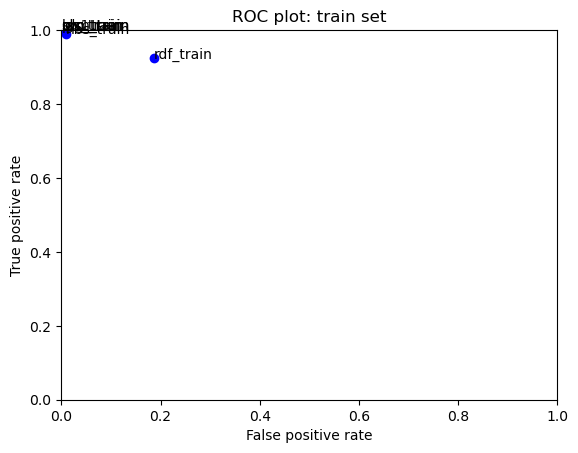

In [15]:
fits = [ols1_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Test Set Performance

### MODEL: ordinary least squares

In [16]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

In [17]:
ols1_performance_test = BinaryClassificationPerformance(ols1.predict(X_test), y_test, 'ols1_test')
ols1_performance_test.compute_measures()
print(ols1_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2109, 'TN': 2097, 'FP': 399, 'FN': 395, 'Accuracy': 0.8412, 'Precision': 0.8409090909090909, 'Recall': 0.8422523961661342, 'desc': 'ols1_test'}


### MODEL: SVM, linear

In [18]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2121, 'TN': 2102, 'FP': 394, 'FN': 383, 'Accuracy': 0.8446, 'Precision': 0.8433399602385686, 'Recall': 0.8470447284345048, 'desc': 'svm_test'}


### MODEL: logistic regression

In [19]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2147, 'TN': 2099, 'FP': 397, 'FN': 357, 'Accuracy': 0.8492, 'Precision': 0.8439465408805031, 'Recall': 0.8574281150159745, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [20]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2134, 'TN': 2077, 'FP': 419, 'FN': 370, 'Accuracy': 0.8422, 'Precision': 0.8358793576184881, 'Recall': 0.8522364217252396, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [21]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2113, 'TN': 2091, 'FP': 405, 'FN': 391, 'Accuracy': 0.8408, 'Precision': 0.8391580619539317, 'Recall': 0.8438498402555911, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [22]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2250, 'TN': 2185, 'FP': 311, 'FN': 254, 'Accuracy': 0.887, 'Precision': 0.878563061304178, 'Recall': 0.8985623003194888, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [23]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2504, 'Neg': 2496, 'TP': 2191, 'TN': 1913, 'FP': 583, 'FN': 313, 'Accuracy': 0.8208, 'Precision': 0.7898341744772891, 'Recall': 0.875, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

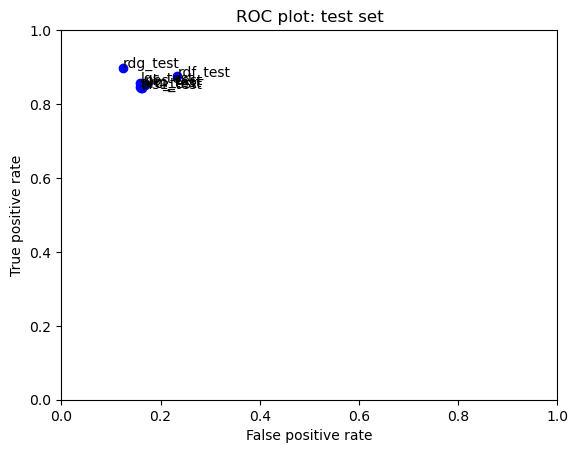

In [24]:
fits = [ols1_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
#fits = [ols1_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### Thought Process

Initially when I tried it without the ngrams ( within Lemma Tokenizer), it seemed like the performance went down overall (decrease in true positive and increase in false positive). Yet OLS model performed incredibly well using modified huber as a parameter; we saw a massive jump in performance in both train & test data. Visually, it seemed like ols did have a SLIGHT increase in performance in true positive and false positive.

When I added the ngrams back in, it gave me a different result. Compared to the previous submission 2, the true positive rates went down slightly for rdg model. Rdf is performing worst among the model, yet overall most of the results are have increased performance with slightly higher true positive and lower false positive rates. The rest of the models are performing around the same amount, while rdg model is performing the best. 

---

# <span style="color:red">SUBMISSION</span>

---

In [25]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/juwonlee/Desktop/ML_23/ML_23-assignments/final_assignment_1/data/moviereviews_test.tsv', my_random_seed=63, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of CountVectorizer X:
(25000, 115716)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count_2  punc_count_3  all_caps
0         131           5             0             0         0
1         169          15             1             0         0
2         176          18             0             0         0
3         112           5           

In [26]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48548


In [27]:
raw_data.head()

,id,review,word_count,punc_count,punc_count_2,punc_count_3,all_caps,upper
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0,0,0,7
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1,0,0,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0,0,0,25
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0,0,0,10
4,12128_7,A very accurate depiction of small time mob li...,133,8,0,0,0,17


In [28]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [29]:
my_submission.shape

(25000, 2)

In [30]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/juwonlee/Desktop/ML_23/ML_23-assignments/final_assignment_1/data/moviereviews_submission3.csv', index=False)